In [ ]:
!pip install --upgrade tensorflow jax jaxlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 101.7 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.5.1
    Uninstalling jaxlib-0.5.1:
      Successfully uninstalled jaxlib-0.5.1
  Attempting uninstall: jax
    Found existing installation: jax 0.5.2
    Uninstalling jax-0.5.2:
      Successfully u

/usr/local/lib/python3.11/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.1 is installed, but it is not compatible with the installed jaxlib version 0.6.0, so it will not be used.
  warnings.warn(


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


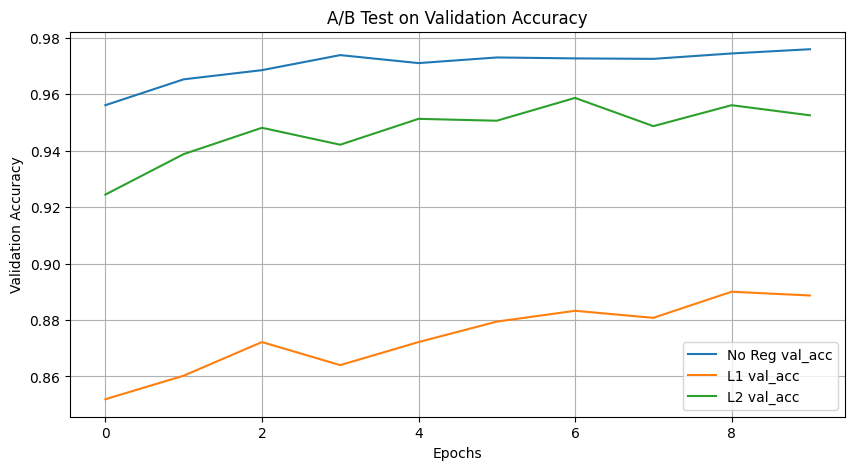

In [ ]:
#A)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Simple model builder for reuse
def build_model(extra_layers=[], regularizer=None, initializer="he_normal", dropout_rate=0.0):
    model = keras.Sequential()
    model.add(layers.Input(shape=(28, 28, 1)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation="relu", kernel_initializer=initializer, kernel_regularizer=regularizer))
    for layer in extra_layers:
        model.add(layer)
    if dropout_rate > 0:
        model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(10, activation="softmax"))
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

def plot_history(histories, labels):
    plt.figure(figsize=(10, 5))
    for history, label in zip(histories, labels):
        plt.plot(history.history['val_accuracy'], label=f"{label} val_acc")
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.title("A/B Test on Validation Accuracy")
    plt.show()

# L2 model
l2_model = build_model(regularizer=regularizers.l2(0.01))
l2_history = l2_model.fit(x_train, y_train, validation_split=0.2, epochs=10, verbose=0)

# L1 model
l1_model = build_model(regularizer=regularizers.l1(0.01))
l1_history = l1_model.fit(x_train, y_train, validation_split=0.2, epochs=10, verbose=0)

# No regularization
baseline_model = build_model()
baseline_history = baseline_model.fit(x_train, y_train, validation_split=0.2, epochs=10, verbose=0)

plot_history([baseline_history, l1_history, l2_history], ["No Reg", "L1", "L2"])

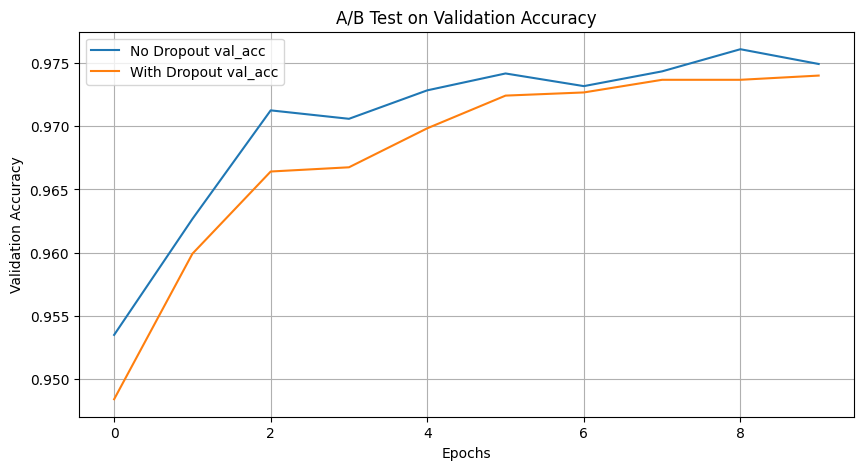

In [ ]:
#b

#dropout
dropout_model = build_model(dropout_rate=0.5)
dropout_history = dropout_model.fit(x_train, y_train, validation_split=0.2, epochs=10, verbose=0)

baseline_model = build_model()
baseline_history = baseline_model.fit(x_train, y_train, validation_split=0.2, epochs=10, verbose=0)

plot_history([baseline_history, dropout_history], ["No Dropout", "With Dropout"])

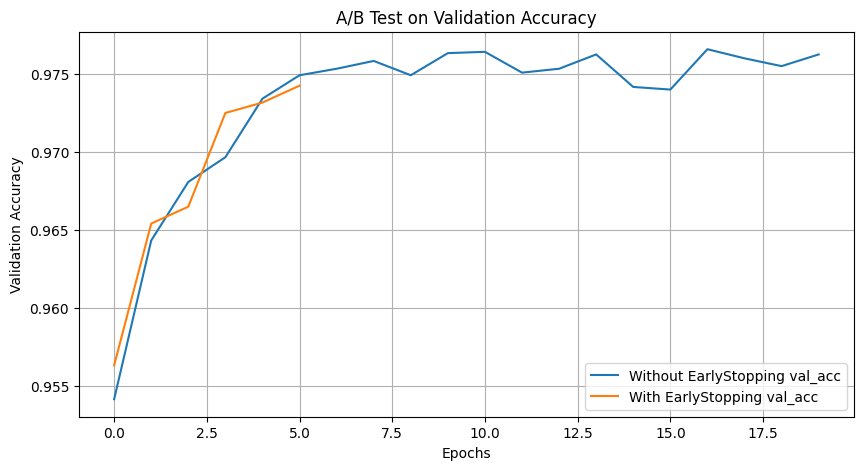

In [ ]:
#c

earlystop = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

early_model = build_model()
early_history = early_model.fit(x_train, y_train, validation_split=0.2, epochs=20, verbose=0, callbacks=[earlystop])

no_early_model = build_model()
no_early_history = no_early_model.fit(x_train, y_train, validation_split=0.2, epochs=20, verbose=0)

plot_history([no_early_history, early_history], ["Without EarlyStopping", "With EarlyStopping"])

In [ ]:
#d

#monte carlo dropout
# Custom function to enable dropout during inference
def monte_carlo_predict(model, x, n_iter=10):
    preds = [model(x, training=True) for _ in range(n_iter)]
    return tf.reduce_mean(preds, axis=0), tf.math.reduce_std(preds, axis=0)

mc_model = build_model(dropout_rate=0.5)
mc_model.fit(x_train, y_train, epochs=5, validation_split=0.2, verbose=0)

mean_preds, std_preds = monte_carlo_predict(mc_model, x_test[:100])
print("Monte Carlo Dropout uncertainty example:")
print("Mean prediction:", np.argmax(mean_preds[0].numpy()))
print("Prediction STD:", std_preds[0].numpy())

Monte Carlo Dropout uncertainty example:
Mean prediction: 7
Prediction STD: [2.35577469e-09 1.52846500e-08 1.06968466e-04 3.65148007e-04
 3.02559757e-12 9.41384926e-09 1.07477876e-13 3.63015017e-04
 1.43676246e-07 1.21825278e-05]


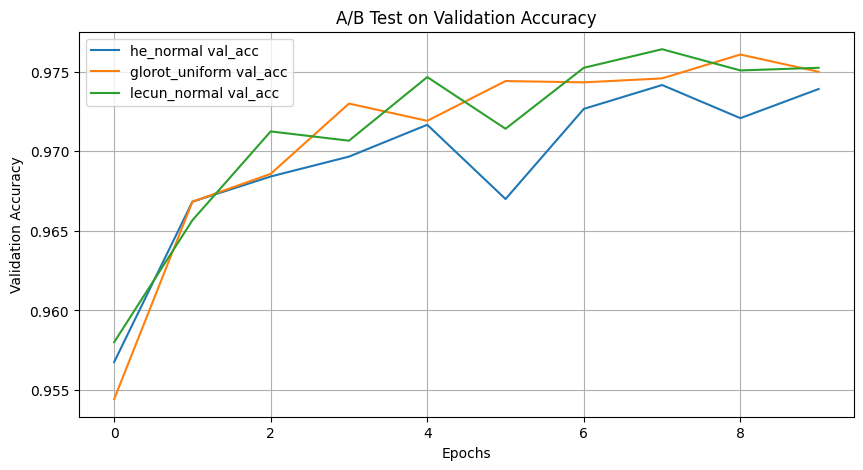

In [ ]:
#e

#various initializing
init_names = ["he_normal", "glorot_uniform", "lecun_normal"]
histories = []

for init in init_names:
    model = build_model(initializer=init)
    history = model.fit(x_train, y_train, validation_split=0.2, epochs=10, verbose=0)
    histories.append(history)

plot_history(histories, init_names)

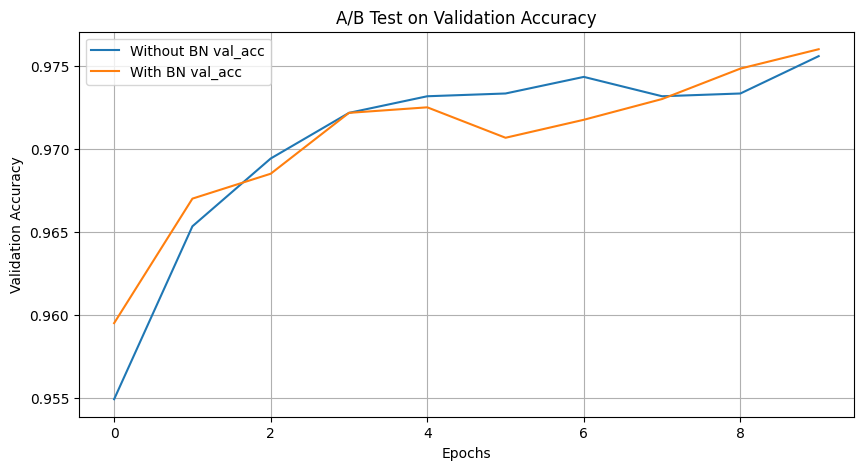

In [ ]:
#f

#batch normalization
bn_model = build_model(extra_layers=[layers.BatchNormalization()])
bn_history = bn_model.fit(x_train, y_train, validation_split=0.2, epochs=10, verbose=0)

no_bn_model = build_model()
no_bn_history = no_bn_model.fit(x_train, y_train, validation_split=0.2, epochs=10, verbose=0)

plot_history([no_bn_history, bn_history], ["Without BN", "With BN"])

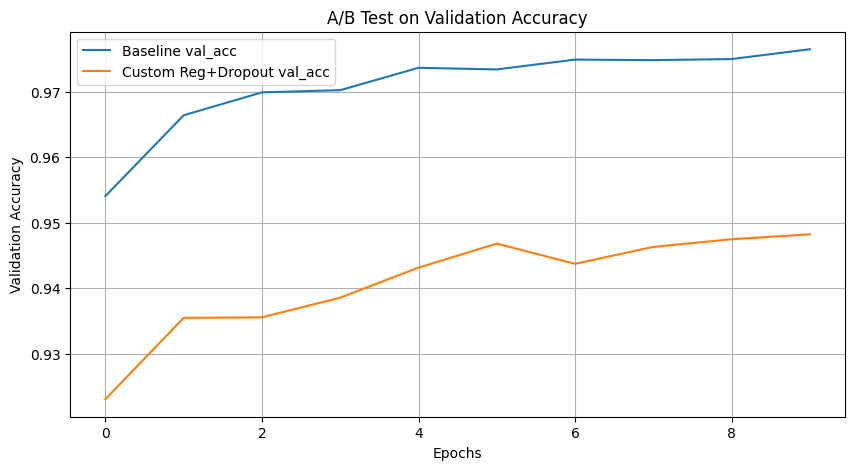

In [ ]:
#g

#cusom Dropout

class CustomDropout(layers.Layer):
    def __init__(self, rate):
        super().__init__()
        self.rate = rate

    def call(self, inputs, training=None):
        if not training:
            return inputs
        return tf.nn.dropout(inputs, rate=self.rate)

class CustomL2Regularizer(regularizers.Regularizer):
    def __init__(self, strength):
        self.strength = strength

    def __call__(self, x):
        return self.strength * tf.reduce_sum(tf.square(x))

custom_model = keras.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Flatten(),
    layers.Dense(128, activation="relu", kernel_regularizer=CustomL2Regularizer(0.01)),
    CustomDropout(0.5),
    layers.Dense(10, activation="softmax")
])

custom_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
custom_history = custom_model.fit(x_train, y_train, validation_split=0.2, epochs=10, verbose=0)

baseline_model = build_model()
baseline_history = baseline_model.fit(x_train, y_train, validation_split=0.2, epochs=10, verbose=0)

plot_history([baseline_history, custom_history], ["Baseline", "Custom Reg+Dropout"])

In [ ]:
#h

#callback and tensorboard

import os, datetime

log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=2)
]

model = build_model()
history = model.fit(x_train, y_train, validation_split=0.2, epochs=15, callbacks=callbacks)

# TensorBoard Magic
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
!pip install -q keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.3 MB/s eta 0:00:00


In [ ]:
#I

import keras_tuner as kt

def model_builder(hp):
    hp_units = hp.Int('units', min_value=32, max_value=256, step=32)
    hp_dropout = hp.Choice('dropout_rate', [0.2, 0.3, 0.5])

    model = keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Flatten(),
        layers.Dense(hp_units, activation='relu'),
        layers.Dropout(hp_dropout),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

tuner = kt.Hyperband(model_builder, objective='val_accuracy', max_epochs=10, directory='keras_tuner_dir', project_name='mnist_tuning')

tuner.search(x_train, y_train, epochs=10, validation_split=0.2)
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 01m 12s]
val_accuracy: 0.9761666655540466

Best val_accuracy So Far: 0.9793333411216736
Total elapsed time: 00h 19m 26s


In [ ]:
!pip install --upgrade tensorflow-text

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 25.4 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-text
    Found existing installation: tensorflow-text 2.18.1
    Uninstalling tensorflow-text-2.18.1:
      Successfully uninstalled tensorflow-text-2.18.1


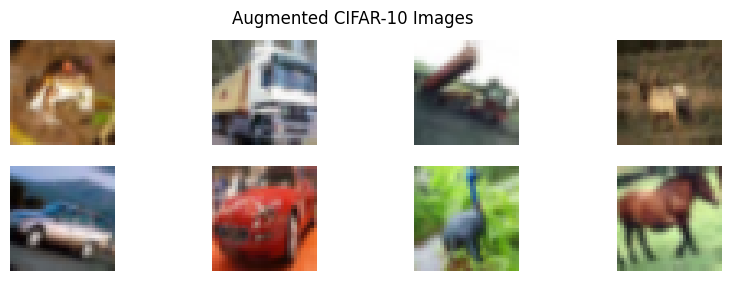

In [ ]:
#J

import keras_cv

# CIFAR-10 data
(x_train, y_train), _ = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype("float32") / 255.0

# Augmentation
augmenter = keras_cv.layers.Augmenter([
    keras_cv.layers.RandomFlip("horizontal"),
    keras_cv.layers.RandomRotation(factor=0.1),
    keras_cv.layers.RandomZoom(height_factor=0.1, width_factor=0.1),
])

# Preview
import matplotlib.pyplot as plt
augmented = augmenter(x_train[:8])
plt.figure(figsize=(10, 3))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(augmented[i])
    plt.axis("off")
plt.suptitle("Augmented CIFAR-10 Images")
plt.show()

In [ ]:
#k

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Augmentation
data_augmenter = keras_cv.layers.Augmenter([
    keras_cv.layers.RandomFlip("horizontal"),
    keras_cv.layers.RandomRotation(0.1),
    keras_cv.layers.RandomZoom(0.1)
])

# Apply aug for A/B
x_train_aug = data_augmenter(x_train)

# Simple CNN
def get_model():
    # Corrected: Use keras.Sequential instead of models.Sequential
    model = keras.Sequential([
        layers.Input(shape=(32,32,3)),
        layers.Conv2D(32, 3, activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation="relu"),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])
    model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# Train A: without aug
model_plain = get_model()
model_plain.fit(x_train, y_train, epochs=5, validation_split=0.2)

# Train B: with aug
model_aug = get_model()
model_aug.fit(x_train_aug, y_train, epochs=5, validation_split=0.2)

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 53s 41ms/step - accuracy: 0.3636 - loss: 1.7455 - val_accuracy: 0.5527 - val_loss: 1.2711
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - accuracy: 0.5841 - loss: 1.1848 - val_accuracy: 0.6237 - val_loss: 1.0921
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 42ms/step - accuracy: 0.6445 - loss: 1.0229 - val_accuracy: 0.6343 - val_loss: 1.0401
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 80s 40ms/step - accuracy: 0.6729 - loss: 0.9334 - val_accuracy: 0.6530 - val_loss: 0.9879
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 56s 45ms/step - accuracy: 0.7059 - loss: 0.8394 - val_accuracy: 0.6780 - val_loss: 0.9406
Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 54s 42ms/step - accuracy: 0.3253 - loss: 1.8552 - val_accuracy: 0.4787 - val_loss: 1.4548
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 52s 41ms/step - accuracy: 0.4930 - loss: 1.4176 - val_accuracy: 0.5235 - val_loss: 1.3608
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 79s 39ms/step - accuracy: 0.5444 - loss: 1

  Using cached torchvision-0.22.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (6.1 kB)
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.


/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,accuracy,time
0,0.207296,0.031955,0.988714,13:05


epoch,train_loss,valid_loss,accuracy,time
0,0.061138,0.005982,0.997547,19:13
1,0.034341,0.003396,0.999019,19:14
2,0.023392,0.003130,0.999509,18:59


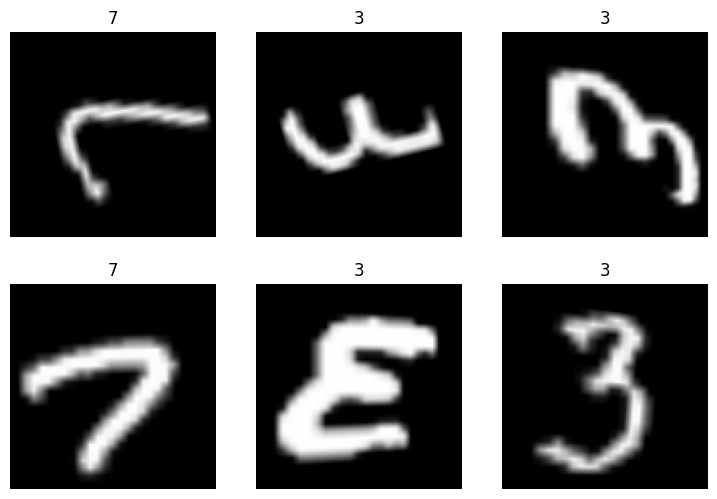

In [ ]:
#L

!pip install --upgrade fastai torchvision

from fastai.vision.all import *

path = untar_data(URLs.MNIST_SAMPLE)
dls = ImageDataLoaders.from_folder(path, train='train', valid='valid', item_tfms=Resize(128),
                                   batch_tfms=aug_transforms(do_flip=True, flip_vert=True, max_rotate=30.0))

learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(3)

# Show augmentations
dls.show_batch(max_n=6)

# Test-Time Augmentation
tta_preds, _ = learn.tta()